In [60]:
import os
from importlib import reload

import numpy as np
import astropy.units as u

import shapely
import sregion

import mastquery
from mastquery import overlaps, query, jwst
import astropy.time

import grizli
from grizli import utils
from grizli.aws import db

import logging
logging.basicConfig(level=logging.INFO,
                    handlers=[logging.StreamHandler(),
                              logging.FileHandler('/tmp/mastquery.log')], 
                    format = "%(module)s.%(funcName)s : %(levelname)s : %(message)s")

print('grizli version: ', grizli.__version__)
print('mastquery version: ', mastquery.__version__)
print('shapely version: ', shapely.__version__)
print('sregion version: ', sregion.__version__)


grizli version:  1.8.11
mastquery version:  1.7.1
shapely version:  2.0.1
sregion version:  1.2.2


## Query for a JWST program

In [61]:
instruments = ['NRC', 'MIR','NIS'] #,'NRS']

# Can change the program name here
filters = jwst.make_program_filter([2514]) # PANORAMIC

# recent days
recent = 7

# Run the query
filters += jwst.make_query_filter('productLevel',
                             values=['1','2','1a','1b','2a','2b'])
res = jwst.query_all_jwst(instruments=instruments, recent_days=recent,
                          filters=filters, columns='*',
                          extensions=['rate','cal', 'trapsfilled', 'rateints','uncal'])

defaults = {'targname':'indef', 'target': 'indef',
            'pupil':'--'}
for k in defaults:
    if k not in res.colnames:
        print(f'Set missing column: {k} = {defaults[k]}')
        res[k] = defaults[k]

print('N: ', len(res))

jwst.query_jwst : INFO : Query JWST NRC


jwst.query_jwst : INFO : Query JWST NRC N=360

jwst.query_jwst : INFO : Query JWST MIR
jwst.query_jwst : WARNING : No files with extensions ['rate', 'cal', 'trapsfilled', 'rateints', 'uncal'] found.
jwst.query_jwst : WARNING : Available extensions are []
jwst.query_jwst : INFO : Query JWST MIR N=0

jwst.query_jwst : INFO : Query JWST NIS
jwst.query_jwst : WARNING : No files with extensions ['rate', 'cal', 'trapsfilled', 'rateints', 'uncal'] found.
jwst.query_jwst : WARNING : Available extensions are []
jwst.query_jwst : INFO : Query JWST NIS N=0

jwst.query_all_jwst : INFO : Apply fixes to JWST query
jwst.query_all_jwst : INFO : Full query on ['NRC', 'MIR', 'NIS'] N=360


Set missing column: targname = indef
Set missing column: target = indef
N:  360


## Parse fields and associations

In [62]:
if 'pupil' not in res.colnames:
    print('set pupil')
    res['pupil'] = '--'

# utils.Unique(res['targname'])
# utils.Unique(res['orig-filter'])
# utils.Unique(res['inst-mode'])

In [63]:
## Unique filenames

res['targname'] = [t.replace(' ','-') for t in res['targname']]
res['target'] = [t.replace(' ','-') for t in res['target']]
res = res[np.in1d(res['instrument_name'], ['NIRISS','NIRCAM','MIRI'])]

# No MIRI spec
res = res[res['inst-mode'] != 'MIRI-None']
res = res[res['targname'] != 'MIRI-SLEW-TO-HOT-TARGET-NORTH']

# MIRI & NIS grism rates
# rate = np.in1d(res['instrument_name'],['MIRI']) 
# rate |= np.in1d(res['orig-filter'],['GR150R','GR150C'])
# if rate.sum() > 0:
#     print(f'Set rate.fits for {rate.sum()} files')
for k in ['dataURI','dataURL']:
    col = res[k].tolist()
    for i, val in enumerate(col):
        _v = val.replace('_cal.fits','_rate.fits').replace('_rateints','_rate')
        _v = _v.replace('_uncal.fits', '_rate.fits')
        _v = _v.replace('_trapsfilled.fits', '_rate.fits')

        col[i] = _v
    
    res.remove_column(k)
    res[k] = col
        
len(res)
un = utils.Unique(res['dataURL'], verbose=False)

keep = res['exptime'] > 0

for i in np.where(np.array(un.counts) > 1)[0]:
    vi = un.values[i]
    j = np.where(un[vi])[0][1:]
    keep[j] = False

mask_mode = utils.column_string_operation(res['inst-mode'], ['MASK','WLP',
                                                             'FND','P750L',
                                                             '1065C','2100C','2300C','1550C','1140C',
                                                             #'GR1','GRIS',
                                                             #'W2',
                                                             'GR700',
                                                             # 'MP','WP',  # NIRISS long
                                                             'NRM',
                                                             'F212N'],
                                          method='count')
keep &= ~mask_mode

if 0:
    keep &= res['instrument_name'] == 'NIRCAM'
    
print(len(res), keep.sum())
ores = res[~keep]
res = res[keep]

360 360


In [64]:
## Test for query results that are already in the db

if True: 
    jw = db.SQL("""
    select status, assoc_name, t_min, "dataURL" from assoc_table where instrument_name in ('NIRISS','NIRCAM','MIRI')
    """)
    old = np.in1d(res['dataURL'], jw['dataURL'])
    print(f'Already in db: {old.sum()}\nTotal: {len(old)}')
    #xres = res[old]
    #res = res[~old]

Already in db: 240
Total: 360


In [65]:
## Summary

import yaml
from grizli import utils

pi = utils.Unique(res['prog_pi'])
pi.exptime = np.array([res['effexptm'][pi[p]].sum() for p in pi.values])

js = {}

for ii in np.argsort(pi.counts):
    p = pi.values[ii]
    targs = np.unique(res['targname'][pi[p]])
    modes = np.unique(res['inst-mode'][pi[p]])
    js[str(p)] = {'N':int(pi.counts[ii]),
             'title': str(res['title'][pi[p]][0].strip()), 
             'targets': [str(t).strip() for t in targs],
             'modes': [str(t).strip() for t in modes]}
    
    print(f"\n ({js[p]['N']}) {p}  | \"{js[p]['title']}\"")
    print(f"   Targets:  {', '.join(js[p]['targets'])}")
    print(f"   Modes:    {', '.join(js[p]['modes'])}")

   N  value     
====  ==========
 360    GO-2514 Williams, Christina C

 (360)   GO-2514 Williams, Christina C  | "PANORAMIC -- A Pure Parallel Wide Area Legacy Imaging Survey at 1-5 Micron"
   Targets:  indef
   Modes:    NIRCAM-F115W, NIRCAM-F150W, NIRCAM-F200W, NIRCAM-F277W, NIRCAM-F356W, NIRCAM-F444W


In [66]:
# summary by detector / filter mode

det_filt = [f'{f}-{d}' for d, f in zip(res['detector'], res['orig-filter'])]
utils.Unique(det_filt)


   N  value     
====  ==========
  12  F115W-NRCA1
  12  F356W-NRCBLONG
  12  F356W-NRCALONG
  12  F277W-NRCBLONG
  12  F277W-NRCALONG
  12  F200W-NRCB4
  12  F200W-NRCB3
  12  F200W-NRCB2
  12  F200W-NRCB1
  12  F200W-NRCA4
  12  F200W-NRCA3
  12  F200W-NRCA2
  12  F200W-NRCA1
  12  F150W-NRCB4
  12  F150W-NRCB3
  12  F150W-NRCB2
  12  F150W-NRCB1
  12  F150W-NRCA4
  12  F150W-NRCA3
  12  F150W-NRCA2
  12  F150W-NRCA1
  12  F115W-NRCB4
  12  F115W-NRCB3
  12  F115W-NRCB2
  12  F115W-NRCB1
  12  F115W-NRCA4
  12  F115W-NRCA3
  12  F115W-NRCA2
  12  F444W-NRCALONG
  12  F444W-NRCBLONG


In [67]:
## Missing Exposures? (FRESCO, UNCOVER) - Nov 15-16    

## The detector/filter combinations should show similar exposure sequences

if True:
    import astropy.table

    res = res[np.argsort(res['t_min'])]
    vexp = ['{visit_id} {filter} {pupil} {detector}'.format(**row) for row in res]

    vv = utils.Unique(vexp, verbose=False)

    jidx = []

    
    for v in vv.values:
        msg = v + ' ' + ' '.join(['{exposure}'.format(**row) for row in res[vv[v]]])
        idx = np.where(vv[v])[0]
        last_exp = -1
        for j in range(len(idx)):
            exp_j = res[idx[j]]['exposure']
            if j < len(idx)-1:
                if res[idx[j+1]]['exposure'] - res[idx[j]]['exposure'] > 1:
                    msg += f' * {exp_j-1}'
                    jidx.append(idx[j+1])
                elif (res[idx[j]]['exposure'] < last_exp) & (res[idx[j]]['exposure'] != 1):
                    msg += f' * {exp_j-1}'
                    jidx.append(idx[j])   
                    # interior 1
                elif (j == 0) & (res[idx[j]]['exposure'] != 1):
                    msg += f' * {exp_j-1}'
                    jidx.append(idx[j])   
                
                last_exp = exp_j
            else:
                # last missing
                pass
            
        print(msg)

    if len(jidx) > 0:
        new_rows = res[jidx].copy()
        new_rows['dataURL'] = [url.replace(f'000{e}_nr', f'000{e-1}_nr')
                               for url, e in zip(new_rows['dataURL'], new_rows['exposure'])]

        new_rows['exposure'] -= 1
        new_rows['dataURL','exposure']
        new_rows['t_min'] -= new_rows['exptime']/86400.
        new_rows['t_max'] -= new_rows['exptime']/86400.

        # Append rows
        res = astropy.table.vstack([res, new_rows])

    res['dataURI'] = res['dataURL']
    res['filename'] = [os.path.basename(f) for f in res['dataURL']]
    res['fileSetName'] = [os.path.basename(f).split('_nrc')[0] for f in res['fileSetName']]

02514053001 NC.F115W CLEAR NRCA1 1 2 3 4
02514053001 NC.F115W CLEAR NRCA2 1 2 3 4
02514053001 NC.F115W CLEAR NRCA3 1 2 3 4
02514053001 NC.F115W CLEAR NRCA4 1 2 3 4
02514053001 NC.F115W CLEAR NRCB1 1 2 3 4
02514053001 NC.F115W CLEAR NRCB2 1 2 3 4
02514053001 NC.F115W CLEAR NRCB3 1 2 3 4
02514053001 NC.F115W CLEAR NRCB4 1 2 3 4
02514053001 NC.F277W CLEAR NRCALONG 1 2 3 4
02514053001 NC.F277W CLEAR NRCBLONG 1 2 3 4
02514054001 NC.F150W CLEAR NRCA1 1 2 3 4
02514054001 NC.F150W CLEAR NRCA2 1 2 3 4
02514054001 NC.F150W CLEAR NRCA3 1 2 3 4
02514054001 NC.F150W CLEAR NRCA4 1 2 3 4
02514054001 NC.F150W CLEAR NRCB1 1 2 3 4
02514054001 NC.F150W CLEAR NRCB2 1 2 3 4
02514054001 NC.F150W CLEAR NRCB3 1 2 3 4
02514054001 NC.F150W CLEAR NRCB4 1 2 3 4
02514054001 NC.F356W CLEAR NRCALONG 1 2 3 4
02514054001 NC.F356W CLEAR NRCBLONG 1 2 3 4
02514055001 NC.F200W CLEAR NRCA1 1 2 3 4
02514055001 NC.F200W CLEAR NRCA2 1 2 3 4
02514055001 NC.F200W CLEAR NRCA3 1 2 3 4
02514055001 NC.F200W CLEAR NRCA4 1 2 3 4
0251

### Parse fields and overlaps

Iter #1, N_Patch = 3


 1 j134348p5549 205.94203165111043 55.819250301731245
target
------
 indef 

filter j134348p5549       NIRCAM NC.F115W   32    8245.8
filter j134348p5549       NIRCAM NC.F150W   32    8245.8
filter j134348p5549       NIRCAM NC.F200W   32    8245.8
filter j134348p5549       NIRCAM NC.F277W    8    2061.5
filter j134348p5549       NIRCAM NC.F356W    8    2061.5
filter j134348p5549       NIRCAM NC.F444W    8    2061.5


 2 j131432p2432 198.63541917141876 24.529541229304165
target
------
 indef 

filter j131432p2432       NIRCAM NC.F115W   32    7558.7
filter j131432p2432       NIRCAM NC.F150W   32    7558.7
filter j131432p2432       NIRCAM NC.F200W   32    7558.7
filter j131432p2432       NIRCAM NC.F277W    8    1889.7
filter j131432p2432       NIRCAM NC.F356W    8    1889.7
filter j131432p2432       NIRCAM NC.F444W    8    1889.7


 3 j121932p0330 184.88026709905415 3.4976894934125
target
------
 indef 

filter j121932p0330       NIRCAM NC.F115W   32    8245.8
filt

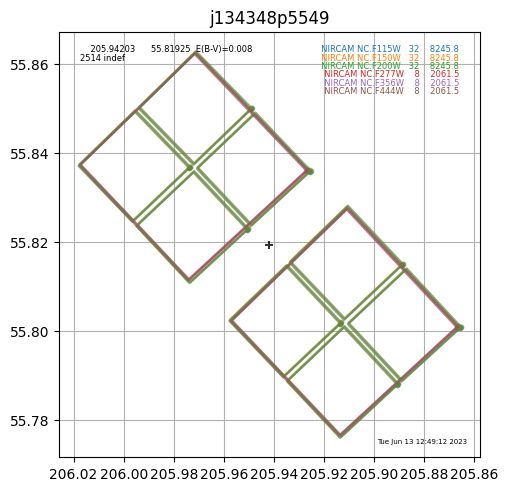

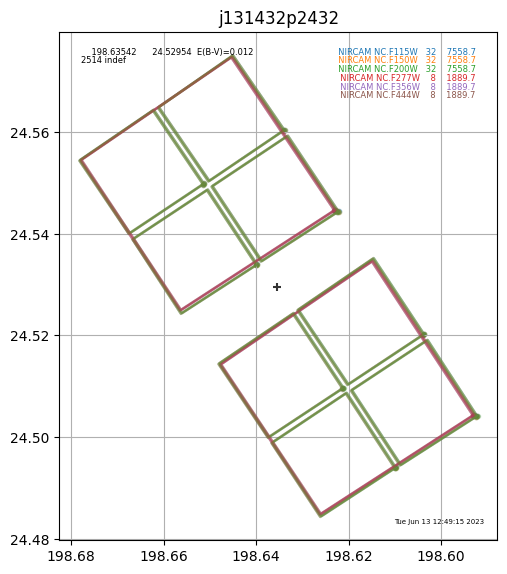

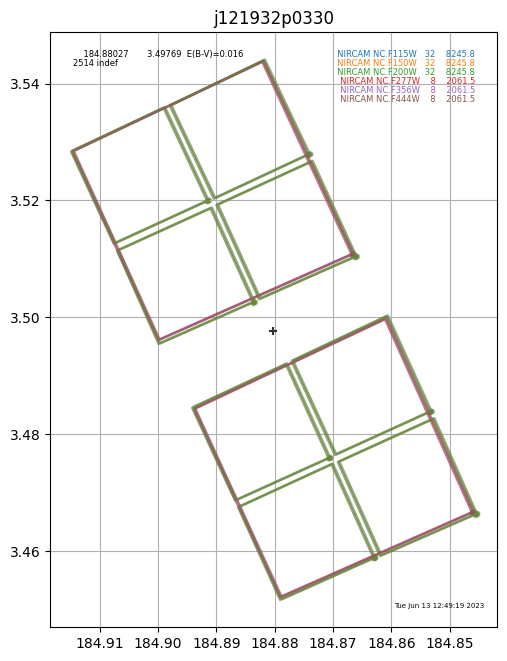

In [68]:
os.chdir('/tmp/')

tabs = overlaps.find_overlaps(res, use_parent=True,
                              patch_alpha=0,
                               buffer_arcmin=25, close=False)

In [69]:
for i, fp in enumerate(tabs[0]['footprint']):
    sr = utils.SRegion(fp)
    if sr.sky_area()[0].value < 1:
        print(i, sr.sky_area())

j134348p5549 nprev=30
0 j134348p5549 30
j131432p2432 nprev=30
1 j131432p2432 30
j121932p0330 nprev=0
2 j121932p0330 30


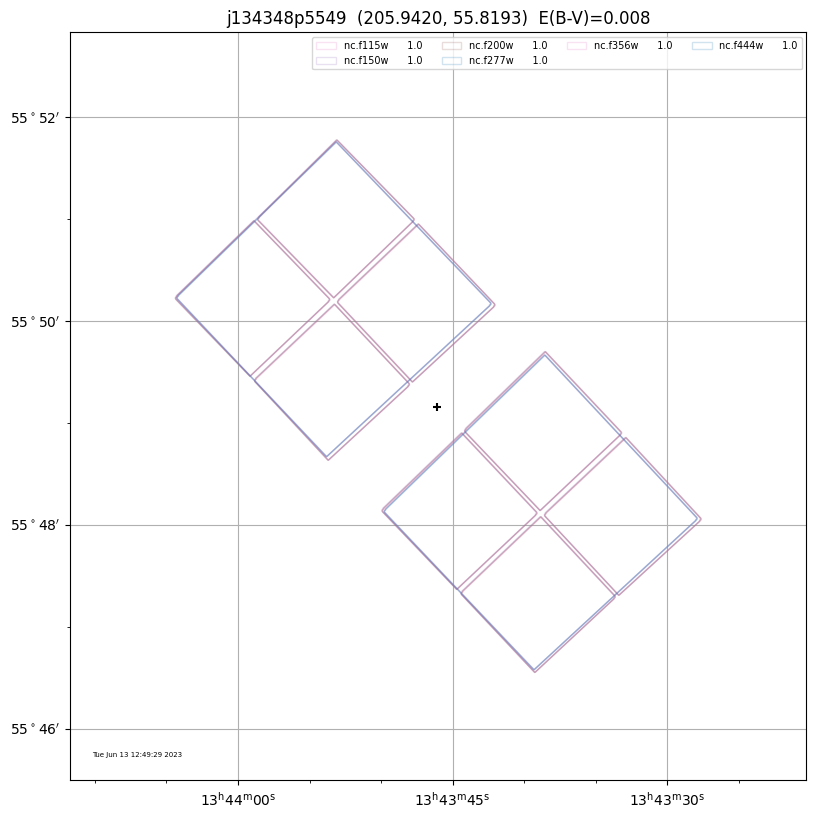

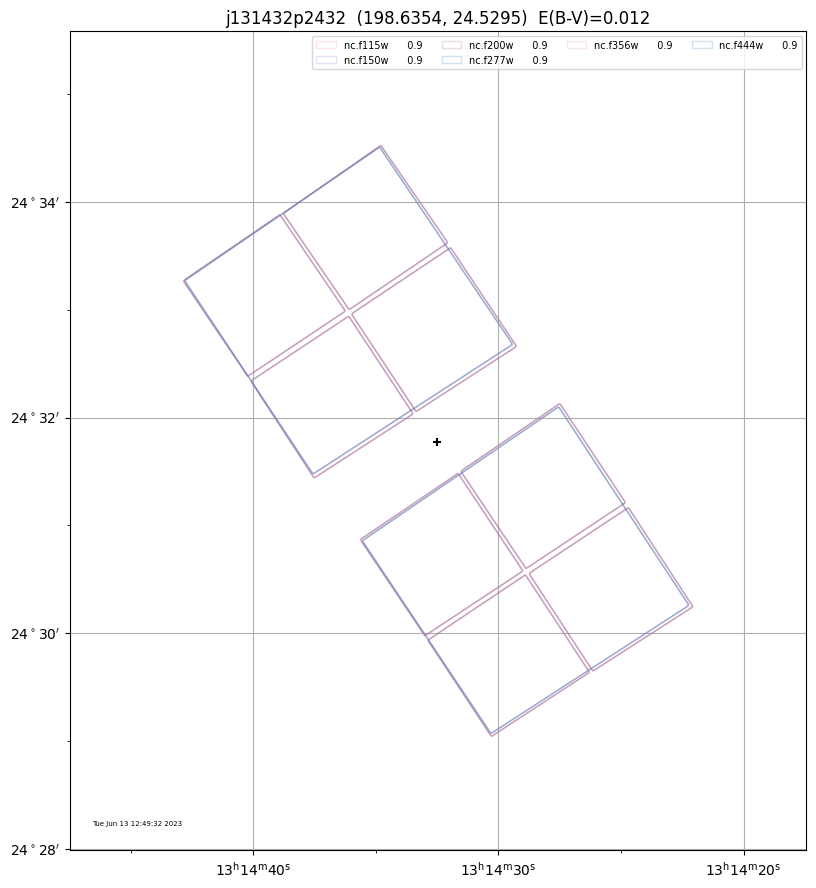

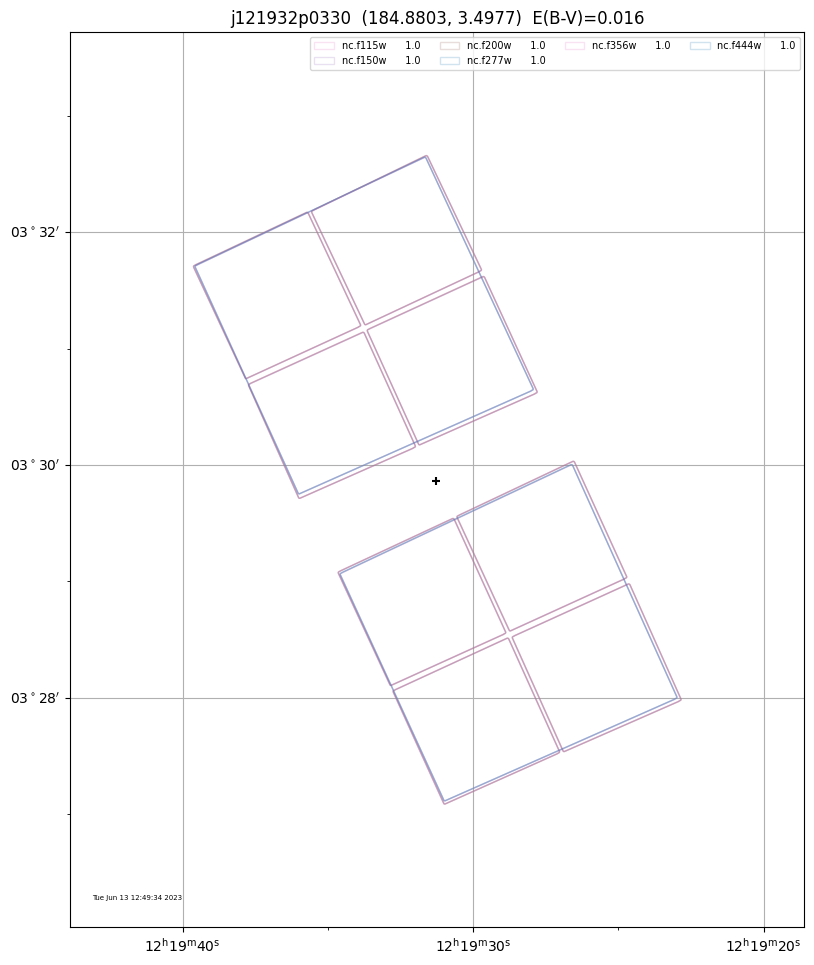

In [70]:
## Split associations

assoc_args = {'max_pa': 5,
                'max_sep': 1.2,
                'max_time': 2.0,
                'match_filter': True,
                'match_instrument': True,
                'match_program': True,
                'hack_grism_pa': False,
                'parse_for_grisms': False, 
                'match_detector':True}

if 1895 in tabs[0]['proposal_id']:
    assoc_args['max_sep'] = 0.5

if 2514 in tabs[0]['proposal_id']:
    # PANORAMIC    
    assoc_args['max_sep'] = 0.9
    assoc_args['max_pa'] = 1090.
    assoc_args['match_program'] = True

LS_ARGS = dict(pixscale=1,
               layers=['ls-dr9', 'sdss', 'unwise-neo7'],
               zorder=-1000,
               alpha=0.8,
               aspect='auto',
               verbose=True,
               grayscale=False,
               grayscale_params=[99, 1.5, -0.02])

for i, tab in enumerate(tabs[:]):
    if (1895 in tab['proposal_id']) & ((tab['dec'] < 0).sum() > 0):
        tab.meta['NAME'] = 'j033236m2745'
        
    nprev = nparent = db.SQL(f"""
select max(assoc_idx) as idx from assoc_table
where parent = '{tab.meta['NAME']}' group by parent
""")
    if len(nprev) == 0:
        assoc_min = 0
    else:
        assoc_min = nprev['idx'][0]+1
    
    print(f"{tab.meta['NAME']} nprev={assoc_min}")
    make_figure=True

    _ = overlaps.split_associations(tab, assoc_min=assoc_min,
                                    assoc_args=assoc_args, force_split=True,
                                    make_figure=make_figure,
                                    with_ls_thumbnail=False,
                                    xsize=8, ls_args=LS_ARGS)
    
    tab['filter'] = tab['filter-pupil']
    tab['parent'] = tab.meta['NAME']
    
    if make_figure:
        _[1].savefig('{0}_footprint.png'.format(tab.meta['NAME']), dpi=150)
    tab.write('{0}_footprint.fits'.format(tab.meta['NAME']), overwrite=True)
    
    print(i, tab.meta['NAME'], len(np.unique(tab['assoc_idx'])))
        
#overlaps.find_overlaps?

In [71]:
## Region files

for tab in tabs:
    if np.unique(tab['target'])[0] == '':
        for k in ['target','targname']:
            tab.remove_column(k)
            tab[k] = 'unknown'
            
for tab in tabs:
    tab['parent'] = tab.meta['NAME']
    tab.write('{0}_footprint.fits'.format(tab.meta['NAME']), overwrite=True)
    
for tab in tabs:
    print(tab.meta['NAME'])
    with open('{0}_footprint.reg'.format(tab.meta['NAME']),'w') as fp:
        fp.write('icrs\n')
        for i, p in enumerate(tab['s_region']):
            sr = utils.SRegion(p)
            for r in sr.region:
                fp.write(r+' # {0}\n'.format(tab['inst-mode'][i]))
                

j134348p5549
j131432p2432
j121932p0330


### Prepare to send to database

Fix column names, etc. to prepare the table in the format for the "assoc_table" table in the `grizli` database.

In [72]:
# Send GLASS test
from grizli.aws import db
import astropy.table

cols = db.SQL('select * from assoc_table limit 3')

tabb = astropy.table.vstack(tabs)

for tab in [tabb]: #tabs:
    tab['filter'] = tab['filter-pupil']

    # Columns in query missing in database
    for c in list(tab.colnames):
        if c not in cols.colnames:
            print(f'Not in database: {c}')
            tab.remove_column(c)

    # Columns in database missing in query
    for c in cols.colnames:
        if c not in tab.colnames:
            print(f'Not in table: {c}')

    # All filters of an association
    assoc_filts = {}
    for ix in np.unique(tab['assoc_idx']):
        _filts = np.unique(('-'.join(np.unique(tab['filter'][tab['assoc_idx'] == ix]).tolist())).split('-')).tolist()
        if 'CLEAR' in _filts:
            _filts.pop(_filts.index('CLEAR'))
        assoc_filts[ix] = '-'.join(_filts)

    # Define assoc_name ** dummy **
    assoc_name = []
    for i, ix in enumerate(tab['assoc_idx']):
        row = tab[i]
        assoc_name.append(('{0}_{1}-{2}_{3:05d}'.format(row['parent'], row['target'], assoc_filts[ix], ix)).lower())
        print(assoc_name[-1])
    
    if 'assoc_name' in tab.colnames:
        tab.remove_column('assoc_name')
        
    tab['assoc_name'] = assoc_name
    tab['status'] = 70

    # Decode bytes
    for c in tab.colnames:
        if isinstance(tab[c][0], str):
            print('Fix str column: ', c)
            col = [s for s in tab[c]]
            tab.remove_column(c)
            tab[c] = col

    # Rename cal > rate for grism
    url = [u.replace('nis_cal','nis_rate') # if 'GR' in fi else u
           for fi, u in zip(tab['filter'], tab['dataURL'])]

    tab['dataURL'] = url
    # For JWST instrument queries, make use dataURI >> dataURL
    #tab.rename_column('dataURI','dataURL')

    #tab['dataURI'] = tab['dataURL']

    # tab['filename'] = [os.path.basename(f)
    #                    for f in tab['dataURL']]

    print(tab.colnames)

utils.set_warnings()
tab = astropy.table.vstack(tabs)
nis = tab['ra'] > 0

so = np.argsort(tab['dataURL'][nis])

# print(tab.colnames)
tab=tabb
tab[nis][so]['dataURL','assoc_name', 'ra', 'dec']### Prepare


Not in database: ArchiveFileID
Not in database: filename
Not in database: fileSetName
Not in database: productLevel
Not in database: act_id
Not in database: apername
Not in database: asnpool
Not in database: asntable
Not in database: bartdelt
Not in database: bendtime
Not in database: bkgdtarg
Not in database: bmidtime
Not in database: bstrtime
Not in database: category
Not in database: datamode
Not in database: dataprob
Not in database: date
Not in database: date_mjd
Not in database: date_end
Not in database: date_end_mjd
Not in database: date_obs
Not in database: date_obs_mjd
Not in database: detector
Not in database: drpfrms1
Not in database: drpfrms3
Not in database: duration
Not in database: effexptm
Not in database: effinttm
Not in database: eng_qual
Not in database: exp_type
Not in database: expcount
Not in database: expend
Not in database: expmid
Not in database: exposure
Not in database: expripar
Not in database: expstart
Not in database: fastaxis
Not in database: frmdivsr
Not

dataURL,assoc_name,ra,dec
str62,str36,float64,float64
mast:JWST/product/jw02514053001_02201_00001_nrca1_rate.fits,j134348p5549_indef-f115w_00031,205.88818514874998,55.80117878725
mast:JWST/product/jw02514053001_02201_00001_nrca2_rate.fits,j134348p5549_indef-f115w-f444w_00037,205.91280959075002,55.78840274
mast:JWST/product/jw02514053001_02201_00001_nrca3_rate.fits,j134348p5549_indef-f115w_00038,205.91137805075002,55.81512804825
mast:JWST/product/jw02514053001_02201_00001_nrca4_rate.fits,j134348p5549_indef-f115w_00032,205.93569031524999,55.80203527075
mast:JWST/product/jw02514053001_02201_00001_nrcalong_rate.fits,j134348p5549_indef-f115w-f277w_00039,205.91220071225,55.80169630975
mast:JWST/product/jw02514053001_02201_00001_nrcb1_rate.fits,j134348p5549_indef-f115w_00033,205.99592381825,55.83685035025
mast:JWST/product/jw02514053001_02201_00001_nrcb2_rate.fits,j134348p5549_indef-f115w-f444w_00034,205.9716677595,55.849863321499996
mast:JWST/product/jw02514053001_02201_00001_nrcb3_rate.fits,j134348p5549_indef-f115w_00035,205.972812442,55.823161320749996
mast:JWST/product/jw02514053001_02201_00001_nrcb4_rate.fits,j134348p5549_indef-f115w_00030,205.94831610525,55.83611353025


In [73]:
nis = tab['ra'] > 0

# First fresco
# nis &= tab['assoc_name'] == 'j033236m2745_unknown-f444w-grismr_00003'

so = np.argsort(tab['dataURL'][nis])

### Check for rows that are already in the database

Based on the unique values in `dataURL`

In [74]:
jw = db.SQL("""
select "dataURL" from assoc_table where instrument_name in ('NIRISS','NIRCAM','MIRI')
""")
old = np.in1d(tab[nis][so]['dataURL'], jw['dataURL'])
print(f'Already in db: {old.sum()}')
print(f'New: {(~old).sum()}')
print(f'Total: {len(old)}')
#xres = res[old]
#res = res[~old]

Already in db: 240
New: 120
Total: 360


In [75]:
# Rename last UNCOVER visits
assoc_name = [a.replace('abell2744-preimg-repeat1-19n47d','abell2744-preimg-rep') for a in tab['assoc_name']]

# Indicate one UNCOVER with a missing exposure
assoc_name = [a.replace('j001420m3022_abell2744-preimg-rep-f115w_00047',
                               'j001420m3022_abell2744-xpreimg-rep-f115w_00047')
                     for a in assoc_name]

# Rename "CLEARP"
assoc_name = [a.replace('-clearp-f', '-f') for a in assoc_name]

is_nis = tab['instrument_name'] == 'NIRISS'
if is_nis.sum() > 0:
    for j in np.where(is_nis)[0]:
        assoc = assoc_name[j]
        if '-nis-' in assoc:
            continue
            
        spl = assoc.split('-')
        new_assoc = '-'.join(spl[:-1]) + '-nis-' + spl[-1]
        assoc_name[j] = new_assoc

tab.remove_column('assoc_name')
tab['assoc_name'] = assoc_name

un = utils.Unique(tab['assoc_name'][nis][so][~old], verbose=False)
xso = np.argsort(un.values)
for j in xso:
    print(f'{un.counts[j]:3} {un.values[j]}')
    

  4 j121932p0330_indef-f115w_00000
  4 j121932p0330_indef-f115w_00001
  4 j121932p0330_indef-f115w_00002
  4 j121932p0330_indef-f115w_00003
  4 j121932p0330_indef-f115w_00005
  4 j121932p0330_indef-f115w_00006
  4 j121932p0330_indef-f115w_00008
  4 j121932p0330_indef-f115w_00009
  4 j121932p0330_indef-f150w_00010
  4 j121932p0330_indef-f150w_00012
  4 j121932p0330_indef-f150w_00013
  4 j121932p0330_indef-f150w_00014
  4 j121932p0330_indef-f150w_00015
  4 j121932p0330_indef-f150w_00016
  4 j121932p0330_indef-f150w_00017
  4 j121932p0330_indef-f150w_00018
  4 j121932p0330_indef-f200w_00020
  4 j121932p0330_indef-f200w_00022
  4 j121932p0330_indef-f200w_00023
  4 j121932p0330_indef-f200w_00024
  4 j121932p0330_indef-f200w_00025
  4 j121932p0330_indef-f200w_00026
  4 j121932p0330_indef-f200w_00027
  4 j121932p0330_indef-f200w_00028
  4 j121932p0330_indef-f277w_00004
  4 j121932p0330_indef-f277w_00007
  4 j121932p0330_indef-f356w_00011
  4 j121932p0330_indef-f356w_00019
  4 j121932p0330_ind

### `assoc_table.status` values

- **70** placeholder, nothing done yet
- **10** data error.  usually for proprietary data with insufficient privileges
- **9** Alignment error
- **2** association has been processed
- **1** Processing in progress
- **0** Automatic script will process these


In [76]:
utils.Unique(tab['status'])

   N  value     
====  ==========
 360          70


In [77]:
# Set status=0 to be processed by the EC2 Launch template
# Generally, don't do this here yet.

if False: # Flip this to True to set status=0
    print('Set status to 0!')
    tab['status'] = 0
else:
    print("Don't change status")

Don't change status


In [80]:
if False:
    db.SQL("""select assoc_name, count(assoc_name), max(status) as status from assoc_table
where proposal_id in ('2362')
group by assoc_name
""")


# Break here when running the full notebook from the start

In [79]:
# break full execution here
print(breakx)

NameError: name 'breakx' is not defined

# Send associations to the database table

In [ ]:
# Send to database 
# Flip False > True to actually send the table, but careful not to send it twice
if False & ((~old).sum() > 0):
    df = tab[nis][so][~old].to_pandas()

    # Send it! 
    print('send to db.assoc_table')
    df.to_sql('assoc_table', db._ENGINE, index=False, if_exists='append', method='multi')
else:
    print("Don't send to db")

Don't send to db


### Modify pipeline parameters for a set of associations

For example, to run 1/f correction along both detector axes.  

The procedure is to put any desired parameters in a YAML file with name `{assoc_name}.yaml` and then upload this to `s3://grizli-v2/HST/Pipeline/Input/`.  The pipeline will look for this file and use any parameters it finds if the file ex

In [ ]:
# Use the working list of associations to send modified parameters
assoc_list = np.unique(tab[nis][so][~old]['assoc_name']).tolist()

In [ ]:
# *OR* Generate a list of associations to modify from the DB
from grizli.aws import db


alist = db.SQL(f"""select assoc_name, count(assoc_name)
FROM assoc_table
where proposal_id in ('2279')
GROUP BY assoc_name
""")

alist

assoc_list = alist['assoc_name'].tolist()
print(alist)

In [ ]:
import os
import yaml

# Aggressive 1/f correction for blank fields
defaults = {'visit_prep_args': {
                'oneoverf_kwargs': {'deg_pix':2048, 'dilate_iterations':3, 'thresholds':[5,4,3]},
                'align_mag_limits': [14, 26.5, 0.1],
            }, 
           }

if not os.path.exists('/tmp/pipeline_defaults'):
    os.mkdir('/tmp/pipeline_defaults')
    
if 1:
    ! rm /tmp/pipeline_defaults/*
    
for assoc in assoc_list:
    # COSMOS-Web
    if ('j095944p0222' in assoc) | ('j100032p0216' in assoc):
        if ('f770w' in assoc) | ('f1800w' in assoc):
            # MIRI
            defaults['global_miri_skyflat'] = True
            defaults['visit_prep_args']['oneoverf_kwargs'] = None
        else:
            # NIRCam
            defaults['visit_prep_args']['oneoverf_kwargs'] =  {'deg_pix':2048, 'dilate_iterations':3,
                                                               'thresholds':[5,4,3], 'other_axis':True}
            defaults['global_miri_skyflat'] = False
            
    else:
        defaults['visit_prep_args']['oneoverf_kwargs'] =  {'deg_pix':2048, 'dilate_iterations':3, 
                                                           'thresholds':[5,4,3],
                                                           'other_axis':True}
    
    with open(f'/tmp/pipeline_defaults/{assoc}.yaml','w') as fp:
        yaml.dump(defaults, fp)
       
if 1:
    ! aws s3 sync /tmp/pipeline_defaults/ s3://grizli-v2/HST/Pipeline/Input/ --acl public-read --exclude "*" --include "*yaml"

rm: cannot remove '/tmp/pipeline_defaults/*': No such file or directory
upload: ../../../tmp/pipeline_defaults/j100736p2109_indef-f115w_00000.yaml to s3://grizli-v2/HST/Pipeline/Input/j100736p2109_indef-f115w_00000.yaml
upload: ../../../tmp/pipeline_defaults/j100736p2109_indef-f115w_00002.yaml to s3://grizli-v2/HST/Pipeline/Input/j100736p2109_indef-f115w_00002.yaml
upload: ../../../tmp/pipeline_defaults/j100736p2109_indef-f115w_00001.yaml to s3://grizli-v2/HST/Pipeline/Input/j100736p2109_indef-f115w_00001.yaml
upload: ../../../tmp/pipeline_defaults/j100736p2109_indef-f115w_00004.yaml to s3://grizli-v2/HST/Pipeline/Input/j100736p2109_indef-f115w_00004.yaml
upload: ../../../tmp/pipeline_defaults/j100736p2109_indef-f150w_00011.yaml to s3://grizli-v2/HST/Pipeline/Input/j100736p2109_indef-f150w_00011.yaml
upload: ../../../tmp/pipeline_defaults/j100736p2109_indef-f115w_00006.yaml to s3://grizli-v2/HST/Pipeline/Input/j100736p2109_indef-f115w_00006.yaml
upload: ../../../tmp/pipeline_defaults/j

## Launch EC2 machines

Will launch *N/2* EC2 machines to parse *N* associations with `status=0`.

In [ ]:
# Look for unprocessed PANORAMIC

pano = db.SQL("""select assoc_name, max(filter) as filter, max(status) as status
from assoc_table
where proposal_id in ('2514')
AND status != 2
group by assoc_name
""")
print(pano)

if False:
    # Set PANORAMIC status to 0 for processing
    db.execute("""update assoc_table set status = 0
where proposal_id in ('2514') and status = 70
""")


assoc_name filter status
---------- ------ ------


In [ ]:
# test: change status on 2362

if 0:
    db.execute("""update assoc_table set status = 70
where proposal_id in ('2362') and status = 1
""")


In [ ]:
from grizli.aws import db, visit_processor

if False:
    _ = visit_processor.launch_ec2_instances(nmax=70, templ='lt-0e8c2b8611c9029eb,Version=33')
else:
    print("Don't launch instances")

Don't launch instances


# Check status of associations in the DB

`assoc_table.status` flags:

- 0 = Will be run by the EC2 machines
- 1 = In process
- 2 = Completed successfully
- 9 = Alignment error
- 10 = Some other error, perhaps no exposures downloaded from MAST
- 12 = Status set for associations manually deleted, don't run them again
- Larger numbers, e.g., 50, 70, 99 - placeholders for associations to skip for now

In [ ]:
from grizli.aws import db
import astropy.time
now = astropy.time.Time.now().mjd

db.SQL(f"""select status, count(distinct(assoc_name)) from assoc_table
where instrument_name in ('NIRISS','NIRCAM','MIRI')
group by status
""")

status,count
int64,int64
2,6922
9,44
10,2
12,1
50,10
70,2747
71,11
99,22


In [ ]:
# Do it again to compare
from grizli.aws import db
import astropy.time
now = astropy.time.Time.now().mjd

db.SQL(f"""select status, count(distinct(assoc_name)) from assoc_table
where instrument_name in ('NIRISS','NIRCAM','MIRI')
group by status
""")

status,count
int64,int64
2,8008
9,44
10,2
12,97
50,10
70,2719
99,22


In [ ]:
db.SQL("""select assoc_name, count(assoc_name), max(proposal_id) as proposal_id
from assoc_table
where status = 12 and instrument_name in ('NIRCAM','NIRISS','MIRI')
group by assoc_name
order by proposal_id
""")


assoc_name,count,proposal_id
str33,int64,str4
j000200m1529_wlm-f430m_00004,4,1334
j100028p0218_cosmos-1-f090w_00129,2,1837
j100028p0218_cosmos-1-f090w_00130,2,1837
j100028p0218_cosmos-1-f090w_00132,2,1837
j100028p0218_cosmos-1-f090w_00133,2,1837
j100028p0218_cosmos-1-f090w_00168,2,1837
j100028p0218_cosmos-1-f090w_00169,2,1837
j100028p0218_cosmos-1-f090w_00173,2,1837
j100028p0218_cosmos-1-f090w_00177,2,1837


In [ ]:
# Change status on associations, etc. Be careful!
if False:
    db.execute("""
update assoc_table set status=0
where status=9
AND parent = 'j100032p0224'
""")

In [ ]:
# What are the status=9 associations executed in the last 10 days where the alignment failed?

import astropy.time
recent = astropy.time.Time.now().mjd - 14

db.SQL(f"""select max(assoc_name) as assoc_name, max(status) as status, max("dataURL") as file, max(modtime) as modtime, max(ra) as ra, max(dec) as dec
FROM assoc_table
where instrument_name in ('NIRISS','NIRCAM','MIRI')
AND status = 2
AND parent = 'j095944p0222'
AND modtime > {recent}
group by assoc_name
order by max(filter) ASC 
""")

In [ ]:
# Reset status on recent abell2744 nrca visits to realign

import astropy.time
from grizli.aws import db
recent = astropy.time.Time.now().mjd - 2

if 0:
    print('Reset assoc status')

    db.execute(f"""update assoc_table set status = 0
    where instrument_name in ('NIRCAM')
    AND status = 2
    AND "dataURL" like '%%nrca%%'
    AND modtime > {recent}
    AND assoc_name like 'j001428m3025%%f277w%%'
    """)
else:
    print('Do nothing')

In [ ]:
'''
# Reset status on recent CEERS visits (data not fully downloaded)
'''

import astropy.time
from grizli.aws import db
recent = astropy.time.Time.now().mjd - 2

if 0:
    print('Reset assoc status')

    db.execute(f"""update assoc_table set status = 49
    where instrument_name in ('NIRCAM','MIRI')
    AND status = 1
    AND "dataURL" like '%%jw01345%%'
    """)
else:
    print('Do nothing')

In [ ]:
db.SQL(f"""select assoc_name, "dataURL" from assoc_table 
    where instrument_name in ('NIRCAM','MIRI')
    AND status = 2
    AND modtime > {recent}
    """)

In [ ]:
# What are the status=9 associations executed in the last 10 days where the alignment failed?

import astropy.time
recent = astropy.time.Time.now().mjd - 10

db.SQL(f"""select max(assoc_name) as assoc_name, max(status) as status, max(modtime) as modtime
FROM assoc_table
where instrument_name in ('NIRISS','NIRCAM','MIRI')
AND status=9
AND modtime > {recent}
group by assoc_name
order by max(modtime) DESC 
""")


In [ ]:
# Unique status=9 associations by "parent" field
db.SQL(f"""select max(parent) as parent, count(distinct(assoc_name)) as count, max(modtime) as modtime
FROM assoc_table
where instrument_name in ('NIRISS','NIRCAM','MIRI')
AND status=9
group by parent
order by max(modtime)
""")

In [ ]:
## HST
db.SQL(f"""select status, count(distinct(assoc_name)) from assoc_table
where instrument_name in ('WFC3/IR','ACS/WFC','WFC3/UVIS')
group by status
""")